# Analysis of Ad-Hoc Communications Network

Jinzhe Zhang
A99000241
jiz114@eng.ucsd.edu

# Setups

## Please click on the `restart kernel and rerun the entire note-book` to make sure all figures are properlly initialized. The whole process may take up to 10 seconds.

Import libraries and setup plot

In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output

`Solver` class inside `solver.py` represents a full simulation of a particular problem size.

In [2]:
from solver import Solver

To start a simulation, we need to create a solver for a particular size, e.g. (20, 20).

`plot_coverage` function plots its current coverage where:


- Black means not covered.
- Dark red means covered.

<IPython.core.display.Javascript object>


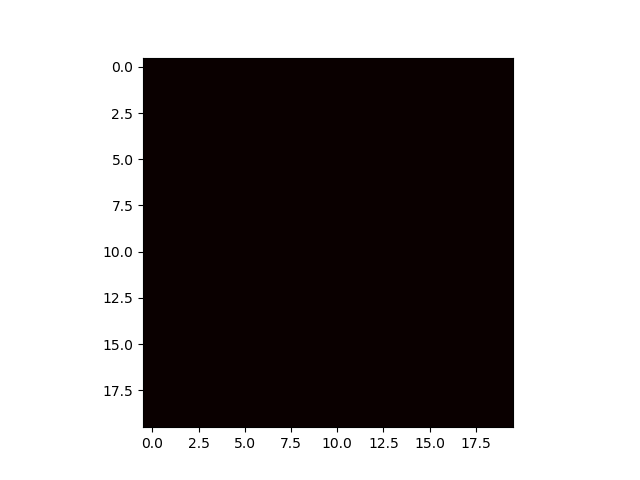

In [3]:
solver = Solver(width=20, height=20)
im = solver.plot_coverage()

# Creating Towers

Now let's create our first tower. `Tower` is a class provided in `tower.py` to represent a single tower. It holds the information about the coordinates and a weakref to the solver.

`Solver` class provides `create_tower` to create a tower with the following calling signature:

> def create_tower(self, x1, x2, y1, y2):

x1, x2, y1, y2 are integer coordinates within the defined space. Note that x1, y1 are **inclusive**, x2, y2 are **exclusive**.

In [4]:
first_tower = solver.create_tower(7, 20, 2, 7)

Now let's add the tower to the current solution. Since it's the first tower, it will not conflict with any existing towers. As a result we don't need to trim it.

`dump_towers` prints out the current towers inside the solution set. Let's also plot the coverage again.

Rank: 1	x1: 7	x2: 20	y1: 2	y2: 7


<IPython.core.display.Javascript object>


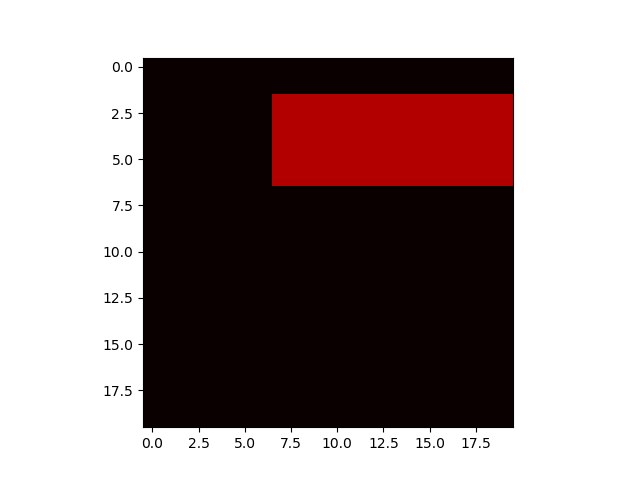

In [5]:
solver.add_tower(first_tower)
print solver.dump_towers()

plt.subplots()
im = solver.plot_coverage()

# Trim the towers

Let's add a few more towers. Coordinates are predefined so that **none of them will overlap.**

Rank: 1	x1: 7	x2: 20	y1: 2	y2: 7
Rank: 2	x1: 1	x2: 4	y1: 6	y2: 10
Rank: 3	x1: 6	x2: 10	y1: 7	y2: 14
Rank: 4	x1: 10	x2: 12	y1: 8	y2: 10
Rank: 5	x1: 15	x2: 19	y1: 8	y2: 12


<IPython.core.display.Javascript object>


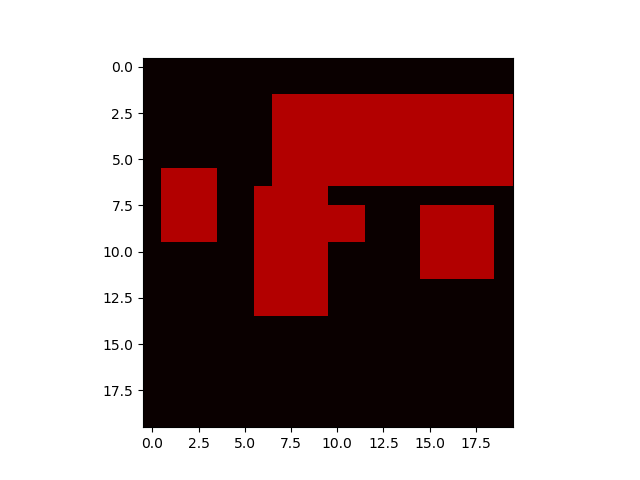

In [6]:
solver.add_tower(solver.create_tower( 1,  4,  6, 10))
solver.add_tower(solver.create_tower( 6, 10,  7, 14))
solver.add_tower(solver.create_tower(10, 12,  8, 10))
solver.add_tower(solver.create_tower(15, 19,  8, 12))

print solver.dump_towers()
plt.subplots()
im = solver.plot_coverage()

Now let's create another tower, which conflicts with **all existing towers**

<IPython.core.display.Javascript object>


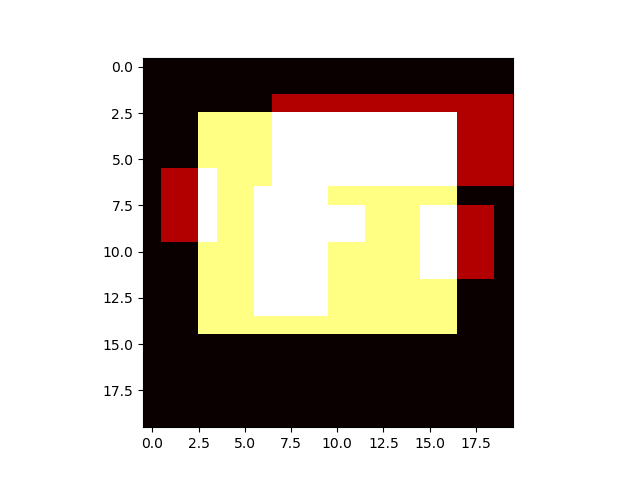

In [7]:
conflict_tower = solver.create_tower( 3, 17,  3, 15)

plt.subplots()
im = solver.plot_coverage_overlay(conflict_tower)

We can't add this tower to the solution. We have to trim it before adding to the solution. `Tower` class has a function `trim` which trims itself based on the current state of the solver it is related to.

Let's see the result of the `trim` and dig into the function after that (White area is the trimmed version):

<IPython.core.display.Javascript object>


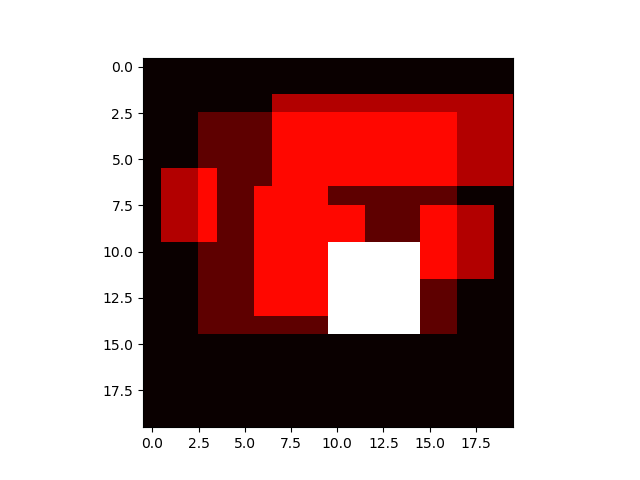

In [8]:
conflict_tower_trimmed = conflict_tower.copy()
conflict_tower_trimmed.trim()

plt.subplots()
im = solver.plot_coverage_overlay(conflict_tower_trimmed, conflict_tower)

# Trim Algorithm

The algorithm used for trim is based on the last algorithm on the following webpage:

[The Maximal Rectangle Problem](http://www.drdobbs.com/database/the-maximal-rectangle-problem/184410529)

Code is adapted for a different orientation so that numpy's native vector operations can be utilized. There are also two bugs in the original pseudo code:

1. When re-pushing a active opening, its original height should be used, instead of the current_height.
2. When closing to an opening that happened to have the same height of the current_height, re-pushing is not needed.

This is an O(MN) algorithm. Actual code can be found in `tower.py`. A description can be found here:

- First of all, the sub-area of the current coverage of the untrimmed region is retrieved from the solver instance
- For each row, a cache recording numbers of continuous empty space up for each column is updated (represent the light cyan area)
- Initialize the `current_height` to 0 and create an empty stack. Scan from left to right.
    - Whenever the cache value is higher than the `current_height`, push an opening to the stack, which consist of the current column id and the height before the opening.
    - Whenever the cache value is lower than the `current_height`, pop openings from the stack until an opening with lower or equal height to the `current_height` is found. And:
        - For each popped openings, compute the area corresponding to the rectangle bounded by the opening and the closing. If a better solution is found, record it.
        

# Tradeoffs

Even though this algorithm is of the complexity O(MN), the current implementation might be sub-optimal because most computation is done in the python domain. The algorithm utilize the nature of the problem and reduced a lot of repeated computation by well designed DP. However, it breaks matrix operation into element wise operations, which has to be executed in the python domain without writing C code.

# Trim Animation Demonstration

Below is an step through animation. Clip on the buttons to control it.

Color legends:

- Black - Blocked
- Dark Cyan - Empty space
- Light Cyan - Current continous space to the up of the current row
- Yellow - Opening ticks
- Purple - Largest rectangle found so far
- White - A new rectangle being examined to see if is larger than the purple one

<IPython.core.display.Javascript object>


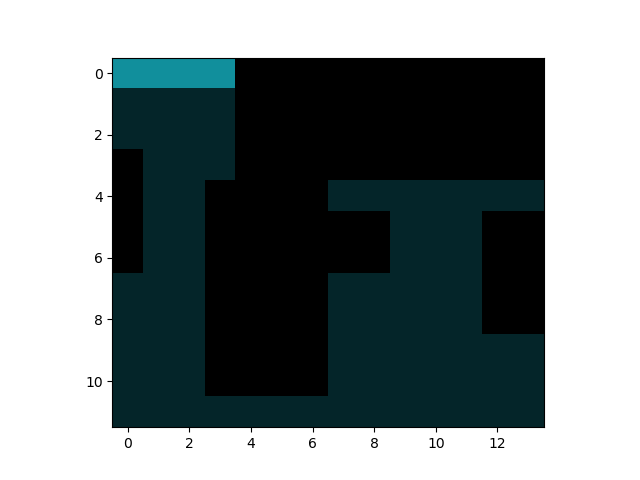

Button(description=u'Reset Animation', style=ButtonStyle())

Button(description=u'Next Step', style=ButtonStyle())

In [9]:
def reset_trim_animation(button=None):
    global _trim_animation
    _trim_animation = conflict_tower.trim_animation()
    _trim_step_button.disabled = False
    step_trim_animation(_trim_step_button)

def step_trim_animation(button=None):
    try:
        _trim_animation.next()
    except StopIteration:
        button.disabled = True
        
plt.subplots()
        
_trim_reset_button = widgets.Button(description="Reset Animation")
_trim_step_button = widgets.Button(description="Next Step")
_trim_reset_button.on_click(reset_trim_animation)
_trim_step_button.on_click(step_trim_animation)
display(_trim_reset_button)
display(_trim_step_button)

reset_trim_animation(_trim_reset_button)

# Generating Random Towers

First, let's create a new solver.

In [10]:
solver2 = Solver(20, 20)

`Solver` class provides multiple functions to generate a random tower:

- `generate_random_tower` Generate a random tower whose size and coordinates are uniformly distributed.
- `generate_random_valid_tower_untrimmed` Generate a random tower, and it is guaranteed that its space not fully covered yet. (Otherwise, it can not be trimmed) This function calls `generate_random_tower` until it returns a valid tower. Before that, this function also checks if the current problem is already solved, i.e. the entire problem space has been covered.
- `generate_random_valid_tower_trimmed` Generate a valid tower (defined above), and trim it before returning.

The following code demostrates `generate_random_valid_tower_untrimmed`. You can click on the button to generate a new tower.

<IPython.core.display.Javascript object>


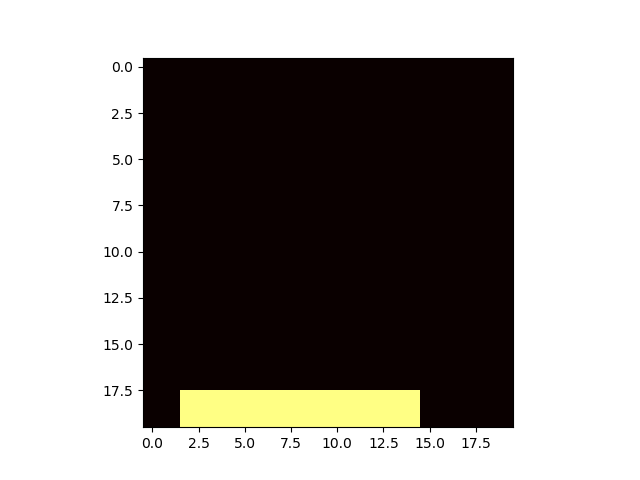

Button(description=u'Generate Tower', style=ButtonStyle())

In [11]:
plt.subplots()
button0 = widgets.Button(description="Generate Tower")

def generate_random_tower(button0):
    global first_tower
    first_tower = solver2.generate_random_valid_tower_untrimmed()
    try:
        solver2.plot_coverage_overlay(first_tower, im=button0.im)
    except AttributeError:
        button0.im = solver2.plot_coverage_overlay(first_tower)

button0.on_click(generate_random_tower)
display(button0)
# Call the function once to generate a tower
generate_random_tower(button0)

# Resolved coverage for a given sequence of towers

Now, let's combine everything above and step through a full simulation. Below the two buttons, there is also a textarea showing the current towers. **You can extend that view to see the tower list.** This animation essentially shows how the problem resolve for a given sequence of towers (randomly chosen here)

<IPython.core.display.Javascript object>


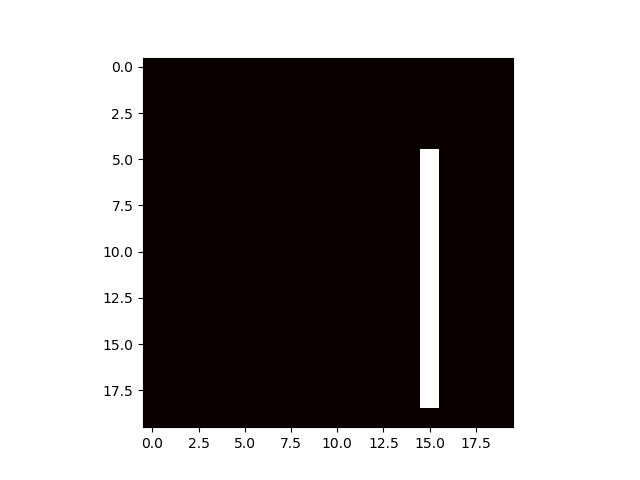

Button(description=u'Reset Simulation', style=ButtonStyle())

Button(description=u'Next Step', style=ButtonStyle())

Textarea(value=u'')

In [12]:
def reset_simulation(button=None):
    solver2.clear()
    _simulation_step_button.disabled = False
    step_simulation(_simulation_step_button)

def step_simulation(button=None):
    try:
        tower_untrimmed = solver2.generate_random_valid_tower_untrimmed()
        tower_trimmed = tower_untrimmed.copy()
        tower_trimmed.trim()
        
        try:
            solver2.plot_coverage_overlay(tower_trimmed, tower_untrimmed, im=button.im)
        except AttributeError:
            button.im = solver2.plot_coverage_overlay(tower_trimmed, tower_untrimmed)
    
        solver2.add_tower(tower_trimmed)
    except RuntimeError: # Simulation finished
        button.disabled = True
    finally:
        _simulation_dump_text.value = solver2.dump_towers()

plt.subplots()
        
_simulation_reset_button = widgets.Button(description="Reset Simulation")
_simulation_step_button = widgets.Button(description="Next Step")
_simulation_reset_button.on_click(reset_simulation)
_simulation_step_button.on_click(step_simulation)
_simulation_dump_text = widgets.Textarea()
display(_simulation_reset_button)
display(_simulation_step_button)
display(_simulation_dump_text)

reset_simulation(_simulation_reset_button)

# Are there any gaps in coverage?

Yes. Through the simulation above, you can see that most tower are trimmed to a much smaller rectangle to prevent overlapping. This often create holes in the coverage which requires at least one extra tower to handle each holes. This is super inefficient.

# Limitation of the algorithm?
`generate_random_valid_tower_untrimmed` is sub-optimal and hurts performance a lot when the problem size is large. The function is perfectly fine when most space is still uncovered. However, as the simulation goes on, this function needs to call `generate_random_tower` a lot of times to get a tower that can be trimmed. There are more complex ways to increase the possibility of the function getting a valid tower by eliminating invalid options.

# Average number of towers required for a full coverage?

The entire simulation is wrapped into a single function `solve_once` without plotting, which returns the number of towers used to cover the entire space:

In [13]:
solver3 = Solver(20, 20)
solver3.solve_once()

38

`solve` function takes a single argument `times` and repeat the problem for that many times. It returns a numpy array.

In [14]:
results = solver3.solve(times=100)
print results

[24 22 30 31 35 36 20 41 14 32 15 21 23 34 37 27 23 25 36 23 24 23 34 20
 17 22 22 26 24 21 11 23 22 21 33 21 19 39 21 12 29 22 42 31 18 27 18 14
 16 23 24 22 24 26 24 26 25 32 28 18 22 25 26 28 27 24 27 21 23 27 37 14
 31 29 20 35 34 24 19 13 12 24 21 24 20 33 15 24 21 33 15 22 15 13 16 25
 22 34 26 24]


To fully utilize all processors, another version with multiprocessing support presents. Because it create a solver on each worker process, the function also needs height and width as its arguments.

In [15]:
from solve_multiprocessing import solve_multiprocessing
results = solve_multiprocessing(height=20, width=20, times=1000)
print results

[18 25 36 31 28 32 40 27 23 19 26 29 28 40 25 38 21 11 23 27 26 22 26 35
 31 28 20 30 21 37 26  8 36 27 39 34 28 22 15 21 19 39 32 30 23 29 16 23
 25 28 19 19 21 35 20  1 15 28 31 33 24 13 39 27 22 31 24 34 18 30 29 28
  8 26 22 27 26 34 23 11 30 11 25 24 19 26 35 31 26 21 25 38 30 28 18 27
 42 19 19 24 37 24 24 17 25 34 24 27  4 16 14 26 23 36 31 24 34 20 31 35
 21  1 14 21 34 19 22 28 33 30 34 26 27 10 21 22 27 31 23 25 19 30 31 23
 30 17 24 27 24 24 36 20 31 28 31 25 18 19 13 22 25 35 31 21 15 27 39 31
 27 32 31 27 24  9 17 28 35 16 39 18 21 28 24 27 29 23 21 23 31 36 22 19
 30 33 18 34 21 30 24 28 39 34 23 39 20 25 11 29 25 29 30 16 37 36 28 21
 24 12 31 33 26 17 21 30 24 36 36 24 12 35 13 20  4 26 31 26 30 39 21 28
 24 23 14 23 29 11 10  9 22 16 21 20 15 10 20 28 25 24 19 24 27 25 22 31
 37 30 13 18 38 29 13 22 22 31 23 23 21 31 32 28 28 17 23 36 25 29 28 16
 26 11 24 22 31 26 32 37 26 24 29 18 29 29 30 23 22 12 27 26 31 37 22 23
 30 25 27 30 34  5 24 25 25 31 19 20 28 17 26 14 30

Let's take a look at its mean and the histogram

In [16]:
results.mean()

24.704

<IPython.core.display.Javascript object>


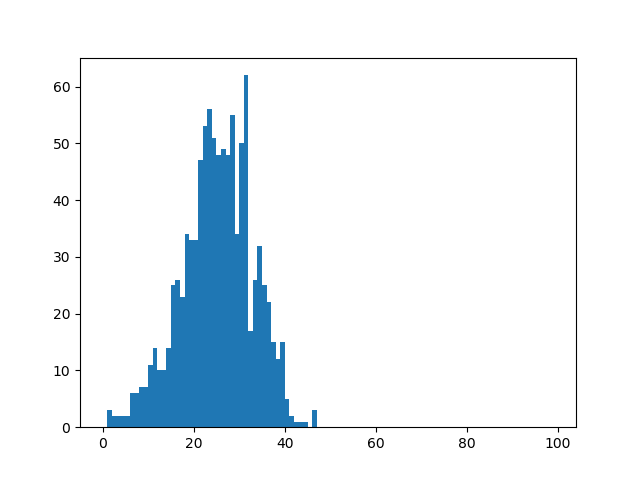

In [17]:
plt.subplots()
_ = plt.hist(results, range(100))

# Saved results

Using similar method, I have run the solver 10000+ times for each of the following size:

> 20x20, 20x40, 40x40, 80x80

Here are the means and histograms:

20x20 24.78140105078809
20x40 32.26609164420485
40x40 42.191304657202835
80x80 66.96002041510718


<IPython.core.display.Javascript object>


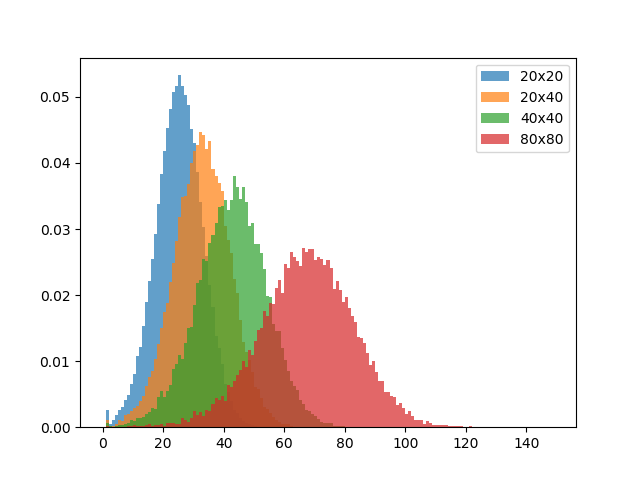

In [18]:
np_arrays = {}
size_list = ["20x20", "20x40", "40x40", "80x80"]
for size in size_list:
    with open("%s.txt" % size) as f:
        py_list = [int(line) for line in f]
    np_arrays[size] = np.array(py_list, dtype=np.uint16)

for size in size_list:
    print size, np_arrays[size].mean()
    
plt.subplots()
for size in size_list:
    plt.hist(np_arrays[size], range(150), normed=True, alpha=0.7, label=size)
_ = plt.legend()

# Insights

- All size have a peak at 1 and another peak near the statistical mean.
- When size increases, mean value increases, samples spreads out more, posibility density is smaller.
- Possibility of getting the full coverage with 1 tower is much more than with 2 towers.
- Run time of larger problem size is significantly slower than small problem size.